In [1]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
import numpy.linalg as LA
import scipy.linalg as sLA

from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, topology_verifier, obtain_phase_center_and_number

In [ ]:
class NonreciprocalTopology3D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()

        self.initiate()

    def get_Hamiltonian_background(self, k):
        n = self.get_n()
        #kx, ky, kz = k
        t0, _ = self.parameters
        hamiltonian = np.zeros((n,n),dtype=complex)

        couplings = [
            [1, 9, [0,0,0], t0], [1, 2, [0,0,0], -t0], [1, 8, [0,0,0], t0],
            [2, 3, [0,0,0], -t0],
            [3, 4, [0,0,0], -t0], [3, 10, [0,0,0], t0],
            [4, 5, [0,0,0], -t0],
            [5, 6, [0,0,0], -t0], [5, 11, [0,0,0], t0],
            [6, 7, [0,0,0], -t0],
            [7, 8, [0,0,0], t0], [7, 12, [0,0,0], t0],
            [9, 13, [0,0,0], t0],
            [10, 15, [0,0,0], t0],
            [11, 17, [0,0,0], t0],
            [12, 19, [0,0,0], t0],
            [13, 14, [0,0,0], t0],
            [13, 20, [0,0,0], -t0],
            [14, 15, [0,0,0], t0],
            [15, 16, [0,0,0], t0],
            [16, 17, [0,0,0], t0],
            [17, 18, [0,0,0], t0],
            [18, 19, [0,0,0], t0],
            [19, 20, [0,0,0], -t0],

            [1, 21, [0,0,0], t0], [1, 22, [0,0,0], -t0], [1, 23, [0,0,0], t0],
            [3, 24, [0,0,0], -t0], [3, 25, [0,0,0], t0], [3, 22, [0,-1,0], -t0],
            [5, 26, [0,0,0], t0], [5, 27, [0,0,0], -t0], [5, 24, [1,0,0], -t0],
            [7, 23, [1,0,0], t0], [7, 28, [0,0,0], t0], [7, 27, [0,1,0], -t0],
            [13, 30, [0,0,0], t0], [13, 29, [0,0,0], -t0], [13, 21, [0,0,1], t0],
            [15, 31, [0,0,0], t0], [15, 25, [0,0,1], t0], [15, 30, [0,-1,0], t0],
            [17, 32, [0,0,0], t0], [17, 26, [0,0,1], t0], [17, 31, [1,0,0], t0],
            [19, 28, [0,0,1], t0], [19, 29, [1,0,0], -t0], [19, 32, [0,1,0], t0]
        ]

        for coupling in couplings:        
            i, j, R, c = coupling
            i = i - 1
            j = j - 1
            hamiltonian[i,j] = hamiltonian[i,j] + c*np.exp(1j*(k @ np.array(R)))
            hamiltonian[j,i] = hamiltonian[j,i] + np.conjugate(c*np.exp(1j*(k @ np.array(R))))

        return hamiltonian

    def get_n(self):
        '''
        n*n Hamiltonian
        '''
        return 32

    def get_n_dim(self):
        return 3

    def get_parameters(self):
        return self.parameters

    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t0'], kwargs['epsilon']

    def get_kpoints(self, n_points=3):    
        # kpoints = list()
        # for kx in np.linspace(-np.pi,np.pi,n_points):
        #     for ky in np.linspace(-np.pi,np.pi,n_points):
        #         for kz in np.linspace(-np.pi,np.pi,n_points):
        #             kpoints.append([kx, ky, kz])
        kpoints = [ik*np.array([0,np.pi,0]) + np.array([0,0,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([np.pi,0,0]) + np.array([0,np.pi,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([-np.pi,-np.pi,0]) + np.array([np.pi,np.pi,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([np.pi,np.pi,np.pi]) + np.array([0,0,0]) for ik in np.arange(0, 1, 1/n_points)]
        kpoints += [ik*np.array([0,0,np.pi]) + np.array([np.pi,np.pi,np.pi]) for ik in np.arange(0, 1+1/n_points, 1/n_points)]

        return kpoints

    def initiate(self):
        t0 = 1
        epsilon = 10*np.random.random()
        self.parameters = t0, epsilon

    def is_real_line_gap(self):
        kpoints = self.get_kpoints(n_points=21)

        hk = self.get_Hamiltonian([0,0,0])
        Es = LA.eigvals(hk)
        n_occ = np.sum(np.real(Es)<0.)

        for kpoint in kpoints:
            hk = self.get_Hamiltonian(kpoint)
            Es = LA.eigvals(hk)
            if np.sum(np.real(Es)<0.) != n_occ:
                return False
        return True  
    
    def is_imaginary_line_gap(self):
        return not self.is_real_line_gap()
    
    def get_Hamiltonian(self, k):
        #kx, ky, kz = k
        #hk = np.zeros((4,4), dtype=complex)
        t0, epsilon = self.parameters
        t1 = t0*epsilon
        t2 = t0/epsilon
        kappa = t2 - t1
        h0 = t1/t0*self.get_Hamiltonian_background(k)

        n = self.get_n()
        gamma = np.zeros((n, n), dtype=complex)

        nonreciprocal_couplings = [
            [2,1,[0,0,0],-kappa], [2,3,[0,0,0],-kappa],
            [4,3,[0,0,0],-kappa], [4,5,[0,0,0],-kappa],
            [6,5,[0,0,0],-kappa], [6,7,[0,0,0],-kappa],
            [8,7,[0,0,0],kappa], [8,1,[0,0,0],kappa],

            [9,1,[0,0,0],kappa], [9,13,[0,0,0],kappa],
            [10,3,[0,0,0],kappa], [10,15,[0,0,0],kappa],
            [11,5,[0,0,0],kappa], [11,17,[0,0,0],kappa],
            [12,7,[0,0,0],kappa], [12,19,[0,0,0],kappa],

            [14,13,[0,0,0],kappa], [14,15,[0,0,0],kappa],
            [16,15,[0,0,0],kappa], [16,17,[0,0,0],kappa],
            [18,17,[0,0,0],kappa], [18,19,[0,0,0],kappa],
            [20,13,[0,0,0],-kappa], [20,19,[0,0,0],-kappa]
        ]
        for coupling in nonreciprocal_couplings:
            i,j,R,c = coupling
            i = i - 1
            j = j - 1
            gamma[i,j] = gamma[i,j] + c*np.exp(1j*(k @ np.array(R)))

        hk =  h0 + gamma 
        if epsilon > 1:
            hk = hk/t1*t0
        hk = hk - self.E_ref*np.identity(n)

        return hk
    
class NonreciprocalTopology3DPerturbation(NonreciprocalTopology3D):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def initiate(self):
        # different parameter region for the different gap type
        t0 = -1 + 2*np.random.random()
        epsilon = 10*np.random.random()
        self.parameters = t0, epsilon
    
    def get_Hamiltonian(self, k):
        hk = super().get_Hamiltonian(k)
        hk = hk*0.05
        return hk

(251, 32)


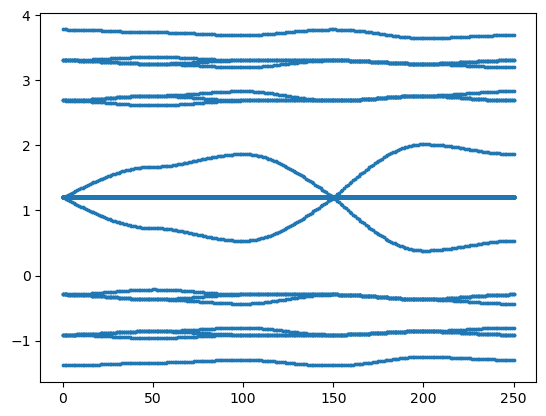

In [67]:
gap_type="real line"
E_ref = -1.2
hamiltonian_model = NonreciprocalTopology3D(E_ref=E_ref)

hamiltonian_model.set_parameters(t0=1.0, epsilon=3.)
kpoints = hamiltonian_model.get_kpoints(n_points=50)
n = hamiltonian_model.get_n()
vs = np.zeros((len(kpoints), n), dtype=complex)
ks = np.zeros((len(kpoints), n))
for ik, k in enumerate(kpoints):
    ks[ik] = ik*np.ones(n)
    vs[ik] = LA.eigvals(hamiltonian_model.get_Hamiltonian(k))

print(vs.shape)
plt.scatter(ks.flatten(),(np.real(vs)).flatten(),s=3)
plt.show()

1.0000000000000002
37.0
Error in calculating the eigenvectors, not full biorthogonal [1.1460317376347926]


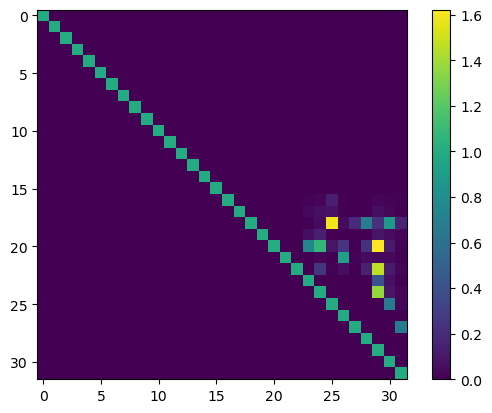

In [68]:
hk = hamiltonian_model.get_Hamiltonian([0.03,  0.    ,0.     ])

values, Lvectors, Rvectors = sLA.eig(hk, left=True, right=True)
Rvectors = np.transpose(Rvectors)
Lvectors = np.transpose(Lvectors)

for i in range(len(values)):
    _v = np.conjugate(Lvectors[i]).dot(Rvectors[i])
    Lvectors[i] = np.conjugate(1/np.sqrt(_v))*Lvectors[i]
    Rvectors[i] = 1/np.sqrt(_v)*Rvectors[i]


Mmat = np.zeros((len(values), len(values)),dtype=complex)
for i in range(len(values)):
    for j in range(len(values)):
        Mmat[i,j] = np.conjugate(Lvectors[i]).dot(Rvectors[j])
Lvectors = np.conjugate(np.transpose(LA.inv(Mmat))).dot(Lvectors)

#print(np.abs(Mmat[:5,:5]))
print(np.abs(LA.det(Mmat)))

plt.figure()
plt.imshow(np.abs(Mmat))
plt.colorbar()

# normalize
Umat = np.zeros((len(values), len(values)),dtype=complex)
for i in range(len(values)):
    for j in range(len(values)):
        Umat[i,j] = np.conjugate(Lvectors[i]).dot(Rvectors[j])
Lvectors = np.conjugate(np.transpose(LA.inv(Umat))).dot(Lvectors)

# print(np.abs(sLA.det(Umat)))

# plt.figure()
# plt.imshow(np.abs(Umat))

Fmat = np.zeros((len(values), len(values)),dtype=complex)
for i in range(len(values)):
    for j in range(len(values)):
        Fmat[i,j] = np.conjugate(Lvectors[i]).dot(Rvectors[j])

# plt.figure()
# plt.imshow(np.abs(Fmat))

check_biorthogonal = 0
for i in range(len(values)):
    check_biorthogonal += np.real(np.conjugate(Lvectors[i]).dot(Rvectors[i]))

print(np.round(check_biorthogonal))

if np.round(check_biorthogonal) != len(values):
    print("Error in calculating the eigenvectors, not full biorthogonal [{0}]".format(check_biorthogonal/len(values)))


Number of samples:  410


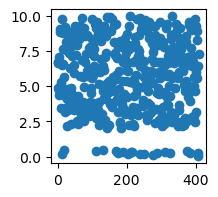

In [69]:
gap_type="real line"
E_ref = -1.2
hamiltonian_model = NonreciprocalTopology3D(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_model, gap_type=gap_type)

n_sample = 500
_models, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

models = list()
for model in _models:
    if model.is_real_line_gap():
        models.append(model)

print("Number of samples: ", len(models))

epsilons = np.zeros(len(models))
for im in range(len(models)):
    _, epsilon = models[im].get_parameters()
    epsilons[im] = epsilon

plt.figure(figsize=(2,2))
plt.scatter(range(len(models)), epsilons)
plt.show()

(1, 7.063482508366825)
(251, 32)


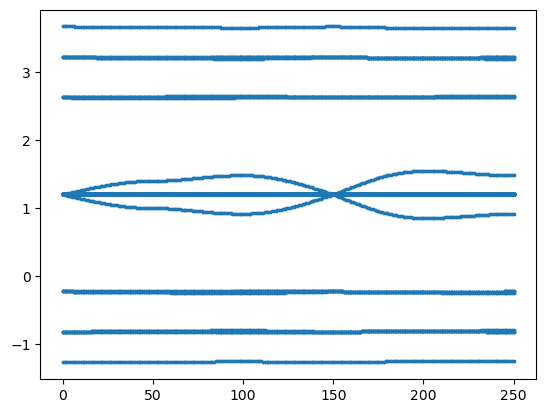

In [70]:
index = 3
kpoints = models[index].hamiltonian.get_kpoints(n_points=50)
print(models[index].get_parameters())
n = models[index].get_n()
vs = np.zeros((len(kpoints), n), dtype=complex)
ks = np.zeros((len(kpoints), n))
for ik, k in enumerate(kpoints):
    ks[ik] = ik*np.ones(n)
    vs[ik] = LA.eigvals(models[index].get_Hamiltonian(k))

print(vs.shape)
plt.scatter(ks.flatten(),(np.real(vs)).flatten(),s=3)
plt.show()

In [71]:
def sfunc(Q1, Q2, c_val=-10):
    n_k = len(Q1)
    for i in range(n_k):
        _Q = Q1[i]+Q2[i]
        #print(np.log10(np.abs(np.linalg.eigvalsh(_Q))))
        for v in np.real(np.linalg.eigvals(_Q)):
            if np.log10(np.abs(v)) < c_val:
                return 0    # has a cross
    return 1

def fast_topology_comparator(topological_model1, topological_model2, kpoints, perturbation=None):
    '''
    Compare two topological models, return the similiarity
    '''
    for k in kpoints:
        Q1 = topological_model1.calculate_Q(kpoints=[k], perturbation=perturbation)
        Q2 = topological_model2.calculate_Q(kpoints=[k], perturbation=perturbation)
        if sfunc(Q1, Q2) == 0:
            return 0

    return 1

In [72]:
from functools import partial
similarity_func = partial(fast_topology_comparator, kpoints=hamiltonian_model.get_kpoints())
cluster = Cluster(similarity_function=similarity_func, verbose=True)
center_indices, group_number = cluster.fit(models)
print(center_indices)
print(group_number)
print("The number of centers: ", len(center_indices))

# cluster = Cluster(similarity_function=topology_comparator, verbose=True)
# center_indices, group_number = cluster.fit(models)
# print(center_indices)
# print(group_number)
# print("The number of centers: ", len(center_indices))

Start to cluster data by my own method with the size as [410] with sc = 0.5.
Clustering ... 
A sample with new topological phase detected! [12]
Done. Spend time as [51.543 seconds]
[ 0 12]
[390  20]
The number of centers:  2


In [74]:
center_models = [models[i] for i in center_indices]

for model in center_models:
    print(model.get_parameters())

hamiltonian_perturbation = NonreciprocalTopology3DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

n_center = len(center_models)
similarity_center = np.zeros((n_center, n_center))
for i in range(n_center):
    for j in range(n_center):
        _similarity = 0
        for perturbation in perturbations:
            if (similarity_func(center_models[i], center_models[j], kpoints=hamiltonian_model.get_kpoints(), perturbation=perturbation) > 0):
                _similarity = 1
        similarity_center[i,j] = _similarity

print(similarity_center)

(1, 6.691363682896468)
(1, 0.22566445106895427)
[[1. 0.]
 [0. 1.]]


In [75]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = NonreciprocalTopology3DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 10
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations, similarity_func=similarity_func)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  real line
The number of phases:  2
[390, 20]


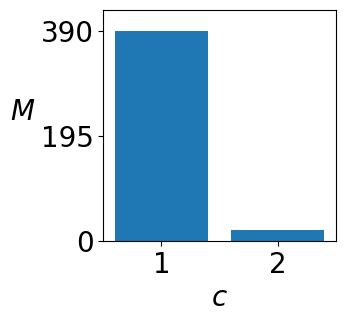

In [76]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

In [77]:
classifier = Classifier(similarity_func=similarity_func, cluster_centers=[models[index] for index in center_indices])
n1 = 201
epsilons = np.linspace(0.001,3,n1)
v_list = np.zeros(n1)

for i in range(n1):
    hamiltonian = NonreciprocalTopology3D(E_ref=E_ref)
    hamiltonian.set_parameters(t0=1.0, epsilon=epsilons[i])
    if hamiltonian.is_real_line_gap():
        _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type=gap_type)
        v_list[i] = classifier.classify(_model)

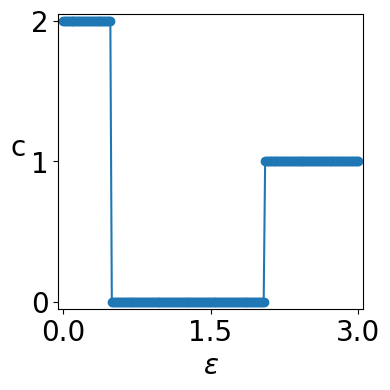

In [79]:
plt.figure(figsize=(4,4))
plt.plot(epsilons, v_list,'-o')
plt.xticks([0, 1.5, 3],fontsize=20)
plt.yticks(range(0, len(group_number)+1),fontsize=20)
plt.xlim([-0.05, 3.05])
plt.ylim([-0.05,len(group_number)+.05])
plt.xlabel(r"$\varepsilon$",fontsize=20)
plt.ylabel(r"c",fontsize=20,rotation=0,horizontalalignment='right')

plt.tight_layout()
plt.show()

# Save data

In [80]:
from tools import save_data, save_data_M

name = "3D_Nonreciprocal_topology"
save_data(new_center_indices, new_group_number, "figs_{0}_group_number.h5".format(name))
save_data_M(v_list, "figs_{0}_phase_diagram.h5".format(name))
print(name)

3D_Nonreciprocal_topology
